In [66]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import yaml
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import roc_curve, auc
from pyedflib import highlevel

In [48]:
# Примерная функция для нормализации
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)


# Класс для подготовки датасета
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.fixed_length = 5000  # Пример длины для padding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Берем данные пациента
        ecg_signal = self.data[idx]

        # Применяем нормализацию к каждому каналу
        ecg_signal = np.array([normalize(ch) for ch in ecg_signal])

        # Padding/Truncation до фиксированной длины
        ecg_signal = self._fix_length(ecg_signal)

        # Преобразование в torch.tensor
        ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return ecg_signal, label

    def _fix_length(self, ecg_signal):
        # Применяем padding или обрезание
        if ecg_signal.shape[1] < self.fixed_length:
            pad_size = self.fixed_length - ecg_signal.shape[1]
            ecg_signal = np.pad(ecg_signal, ((0, 0), (0, pad_size)), "constant")
        else:
            ecg_signal = ecg_signal[:, : self.fixed_length]
        return ecg_signal


def create_weighted_sampler(labels):
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights, num_samples=len(labels), replacement=True
    )
    return sampler


import pickle

with open("../../../Data/dumped/X_train.pkl", "rb") as f:
    f.seek(0)
    X_train = pickle.load(f)
with open("../../../Data/dumped/y_train.pkl", "rb") as f:
    f.seek(0)
    y_train = pickle.load(f)
with open("../../../Data/dumped/X_test.pkl", "rb") as f:
    f.seek(0)
    X_test = pickle.load(f)
with open("../../../Data/dumped/y_test.pkl", "rb") as f:
    f.seek(0)
    y_test = pickle.load(f)

print(X_train.shape)
print(y_train.shape)
y_train = np.concatenate([y_train, y_train], axis=0)
Y_train = y_train[0].astype("int8")
Y_test = y_test[0].astype("int8")
# Y_train = y_train
# Y_test = y_test
# Y_train = F.one_hot(torch.LongTensor(y_train[0]), num_classes=2).double()
# Y_train.double()
# Y_test = F.one_hot(torch.LongTensor(y_test[0]), num_classes=2).double()
# Y_test.double()
# Y_train = y_train[0]
# Y_test = y_test[0]

(132, 8, 5000)
(2, 132)


In [49]:
# sampler = create_weighted_sampler(torch.LongTensor(Y_train))
sampler = None
train_dataset = ECGDataset(data=X_train, labels=Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
# train_loader = DataLoader(train_dataset, batch_size=32)

test_dataset = ECGDataset(data=X_test, labels=Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
with open("./config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [51]:
from torch import nn


class MultiBranchECGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=3):
        super(MultiBranchECGNet, self).__init__()

        # Ветви для каждого канала (CNN)
        self.branches = nn.ModuleList(
            [self.create_branch() for _ in range(num_channels)]
        )

        # Attention слой для агрегации информации между каналами
        self.attention = nn.MultiheadAttention(
            embed_dim=128, num_heads=8, batch_first=True
        )

        # Линейный слой для выравнивания размерности перед attention
        self.linear_attn = nn.Linear(num_channels * 128, 128)

        # Полносвязные слои для классификации
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.drop = nn.Dropout(p=config["model"]["parameters"]["dropout_rate"])

    def create_branch(self):
        """Создаем сверточную ветвь для каждого канала"""
        branch = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),  # Свертка с padding
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # Вторая сверточная операция
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),  # Третья сверточная операция
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        return branch

    def forward(self, x):
        # x shape: [batch_size, num_channels, seq_len]

        # Обрабатываем каждый канал через свою ветвь (CNN для каждого канала)
        branch_outputs = []
        for i in range(x.size(1)):  # num_channels
            branch_output = self.branches[i](
                x[:, i : i + 1, :]
            )  # Обрабатываем i-й канал, [batch_size, 1, seq_len]
            branch_outputs.append(branch_output)

        # Объединяем выходы ветвей
        out = torch.stack(
            branch_outputs, dim=1
        )  # [batch_size, num_channels, 128, reduced_seq_len]

        # out = out.mean(dim=-1)  # Усредняем по временной оси: [batch_size, num_channels, 128]

        # # Применяем multi-head attention для межканальной агрегации
        # out, _ = self.attention(out, out, out)  # [batch_size, num_channels, 128]

        # # Flatten the output
        # out = torch.flatten(out, start_dim=1, end_dim=2)  # [batch_size, num_channels * 128]

        # Меняем форму, чтобы соответствовать входу MultiheadAttention: [batch_size, reduced_seq_len, num_channels * 128]
        batch_size, num_channels, embed_dim, seq_len = out.shape
        out = out.permute(0, 3, 1, 2).reshape(batch_size, seq_len, -1)

        out = F.relu(self.linear_attn(out))

        # Применяем Multihead Attention ко всей последовательности
        out, _ = self.attention(
            out, out, out
        )  # [batch_size, seq_len, num_channels * 128]

        # Усредняем по временной оси
        out = out.mean(dim=1)  # [batch_size, num_channels * 128]

        # Полносвязные слои для классификации
        out = F.relu(self.drop(self.fc1(out)))
        out = self.fc2(out)  # [batch_size, num_classes]
        return out


# Пример использования
model = MultiBranchECGNet(num_channels=8, num_classes=2)

Validation recall: 0.8750
Validation accuracy: 0.8750
Validation precision: 0.5833

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92        40
           1       0.58      0.88      0.70         8

    accuracy                           0.88        48
   macro avg       0.78      0.88      0.81        48
weighted avg       0.91      0.88      0.88        48

Матрица несоответствий для тестовой выборки метода ЛДА:



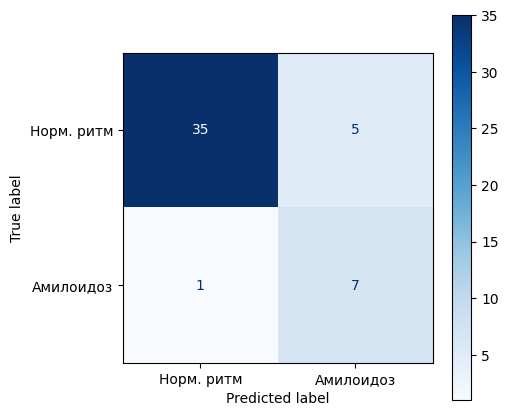

In [70]:
def validate_model(model, dataloader):
    model = MultiBranchECGNet(num_channels=8, num_classes=2)
    model.load_state_dict(torch.load("model_weights.pth", weights_only=True))
    model.eval()  # Переводим модель в режим оценки
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Отключаем градиенты для валидации
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Предсказания с максимальной вероятностью
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Преобразуем в numpy массивы
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Считаем accuracy
    recall = recall_score(all_labels, all_preds)
    print(f"Validation recall: {recall:.4f}")
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation accuracy: {accuracy:.4f}")
    precision = precision_score(all_labels, all_preds)
    print(f"Validation precision: {precision:.4f}")

    class_names = ["Норм. ритм", "Амилоидоз"]

    print("\n clasification report:\n", classification_report(all_labels, all_preds))

    print("Матрица несоответствий для тестовой выборки метода ЛДА:\n")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(
        confusion_matrix(all_labels, all_preds), display_labels=class_names
    )
    disp.plot(cmap="Blues", ax=ax)

    return all_preds


# Пример вызова валидации
all_preds = validate_model(model, test_loader)

In [54]:
import matplotlib.pyplot as plt

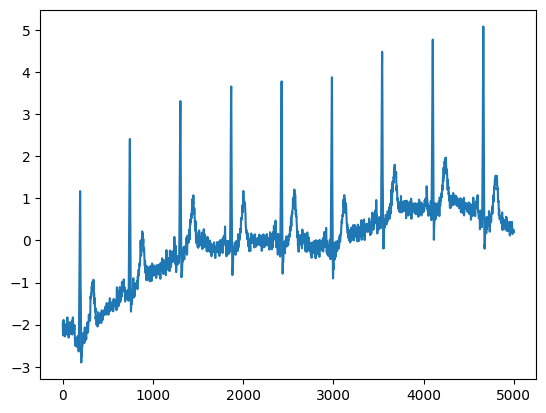

In [73]:
inputs, labels = next(iter(test_loader))
dl_value = inputs[1]
plt.plot(dl_value[0])

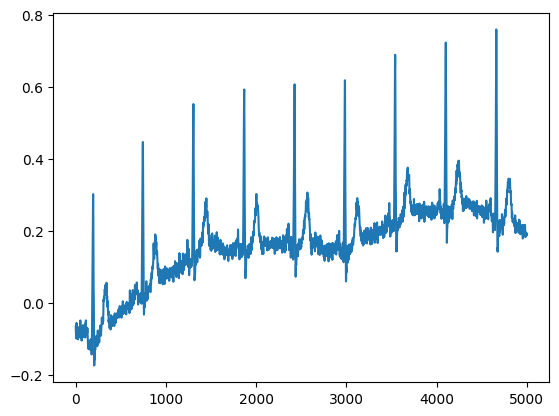

In [74]:
signals, signal_headers, _ = highlevel.read_edf(y_test[1][1]["filename"].__str__())
orig_value = signals[0]
plt.plot(orig_value)

## Nice. Metadata corresponds with files!

In [90]:
import pandas as pd

all_filenames = [
    x["filename"].relative_to("/home/kravchenko.artem/Projects/Diplomas").__str__()
    for x in y_test[1]
]
print(all_filenames)
results_dataframe = pd.DataFrame(
    {"Filename": all_filenames, "label": y_test[0], "Multibranch_predict": all_preds}
)

['Data/AMY_add/AMY/2/AMYC12.edf', 'Data/AMY_add/AMY/2/AMYC13.edf', 'Data/AMY_add/AMY/2/AMYC20.edf', 'Data/AMY_add/AMY/2/AMYC65.edf', 'Data/AMY_add/AMY/2/AMYC85.edf', 'Data/AMY_add/AMY/2/AMYC71.edf', 'Data/AMY_add/AMY/2/AMYC45.edf', 'Data/AMY_add/AMY/2/AMYC35.edf', 'Data/AMY_add/AMY/2/AMYC52.edf', 'Data/AMY_add/AMY/2/AMYC10.edf', 'Data/AMY_add/AMY/2/AMYC44.edf', 'Data/AMY_add/AMY/2/AMYC46.edf', 'Data/AMY_add/AMY/2/AMYC61.edf', 'Data/AMY_add/AMY/2/AMYC30.edf', 'Data/AMY_add/AMY/2/AMYC26.edf', 'Data/AMY_add/AMY/2/AMYC83.edf', 'Data/AMY_add/AMY/2/AMYC23.edf', 'Data/AMY_add/AMY/2/AMYC47.edf', 'Data/AMY_add/AMY/2/AMYC92.edf', 'Data/AMY_add/AMY/2/AMYC34.edf', 'Data/AmyC/AmyC/AmyC5.edf', 'Data/AmyC/AmyC/AmyC25.edf', 'Data/AmyC/AmyC/AmyC44.edf', 'Data/AmyC/AmyC/AmyC12.edf', 'Data/AmyC/AmyC/AmyC31.edf', 'Data/AmyC/AmyC/AmyC42.edf', 'Data/AmyC/AmyC/AmyC33.edf', 'Data/AmyC/AmyC/AmyC32.edf', 'Data/AmyC/AmyC/AmyC37.edf', 'Data/AmyC/AmyC/AmyC1.edf', 'Data/AmyC/AmyC/AmyC26.edf', 'Data/AmyC/AmyC/AmyC22

In [91]:
results_dataframe.head()

,Filename,label,Multibranch_predict
0,Data/AMY_add/AMY/2/AMYC12.edf,0.0,0
1,Data/AMY_add/AMY/2/AMYC13.edf,0.0,0
2,Data/AMY_add/AMY/2/AMYC20.edf,0.0,0
3,Data/AMY_add/AMY/2/AMYC65.edf,0.0,0
4,Data/AMY_add/AMY/2/AMYC85.edf,0.0,1


In [92]:
results_dataframe.to_csv("predictions.csv")